In [1]:
import math
import random
import torch
import torchvision
import time 
from torchvision import datasets ,transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader,Dataset
from torch import nn 
from torch.nn.functional import relu ,softmax 
import copy 
from torch.utils.data import Subset
import pandas as pd 
import numpy as np
from PIL import Image
 


In [2]:
data_transform=transforms.Compose ([transforms.ToTensor()])


In [3]:


class light_source_dataset(Dataset):
    def __init__(self,path,transform):
        self.df_data=pd.read_csv(path)
        self.df_data['Classifier'] = pd.Categorical(pd.factorize(self.df_data['Classifier'])[0])
        self.labels=np.asarray(self.df_data.iloc[:,self.df_data.shape[1]-1])
        self.image_as_np=np.asarray(self.df_data.iloc[:,0:self.df_data.shape[1]-1]).astype('uint8')
        self.trans=transform
        
    def __len__(self):
        return len(self.df_data.index)
    def __getitem__(self,index):
        image_np=self.image_as_np[index,:,None]
       
        pillow_image=Image.fromarray(image_np.astype('uint8'))
        
        single_label=self.labels[index]
        if (self.trans is not None):
            img_as_tensor=self.trans(pillow_image)
        
        
            
        return (img_as_tensor,single_label)
        
dataset=light_source_dataset('WaveformEW\WaveformEW.csv',data_transform)
print(len(dataset))
train_size=int (len(dataset)*0.6)
test_size=len(dataset)-train_size
trainloader=DataLoader(dataset,batch_size=1)
torch.manual_seed(1)
train_data,test_data=torch.utils.data.random_split(dataset,[int (train_size), int (test_size)])
dataloader={'train':DataLoader(train_data,shuffle=False ,batch_size=16),
            'val':DataLoader(test_data,shuffle=False,batch_size=16
                            )}

dataset_sizes={'train':len(train_data),
               'val':len(test_data)}

device=torch.device("cuda:0"if torch.cuda.is_available () else "cpu")
print(dataset_sizes["train"])
print (dataset_sizes["val"])
#for images,labels in dataloader['train']:
 #   print(labels)

 
    



5000
3000
2000


In [4]:

class Model(torch.nn.Module):
    def __init__(self):
        super (Model,self ).__init__()
        self .linear1=nn.Linear (40,20)
        self.linear2=nn.Linear (20,3)
        
    def Forward (self,x,mask,p):
        #feed forward function 
        x=x.view(-1,40)
        act1=relu(self.linear1(x))
        act1_masked =self.masking (act1,mask,p)
        act2=softmax(self.linear2(act1_masked ))
        return act2
    
    
    
    def masking (self,act1,mask,p):
        if (self.training ==True ):
            return ((act1*mask)/p)
        else :
            return (act1)
        



  
  
  


      

In [5]:
def train_model(model, criterion, optimizer,mask,p, num_epochs=25):
  # the mask has to be specified 

      
      since = time.time()

      best_model_wts = copy.deepcopy(model.state_dict())
      best_acc = 0.0
      losses=[]
      accuracies=[]

      for epoch in range(num_epochs):
          print('Epoch {}/{}'.format(epoch, num_epochs - 1))
          print('-' * 10)

          # Each epoch has a training and validation phase
          for phase in ['train', 'val']:
              if phase == 'train':
                  
                  model.train()  # Set model to training mode
              else:

                  model.eval()   # Set model to evaluate mode

              running_loss = 0.0
              running_corrects = 0

              # Iterate over data.
              for inputs, labels in dataloader[phase]:
                inputs=inputs.to(device)
                labels=labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs= model.Forward(inputs,mask,p)

                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)# backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        #print (model.linear1.weight.grad)
                        #print (model.linear2.weight.grad)

                  # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
                  

              epoch_loss = running_loss / dataset_sizes[phase]
              epoch_acc = running_corrects.double() / dataset_sizes[phase]
            

              print('{} Loss: {:.4f} Acc: {:.4f} '.format(
                  phase, epoch_loss, epoch_acc))

              # deep copy the model
              if phase == 'val' and epoch_acc > best_acc:
                  best_acc = epoch_acc
                  best_model_wts = copy.deepcopy(model.state_dict())
              if phase=='train':
                losses.append(epoch_loss)
                accuracies.append(epoch_acc)


          

      time_elapsed = time.time() - since
      print('Training complete in {:.0f}m {:.0f}s'.format(
          time_elapsed // 60, time_elapsed % 60))
      print('Best val Acc: {:4f}'.format(best_acc))

      # load best model weights
      model.load_state_dict(best_model_wts)
      return model,losses,accuracies

In [6]:

class Population:
    
    def __init__(self,m,num,maskLength):
        # constructor for initialising the population list
        #list of DNA objects
        self.population=[]
        #muation rate for mutation
        self.mutation_rate=m
        #maximum number of entities in the population
        self.popmax=num

        self.maskLength=maskLength
        for i in range (num):
            #creating a dna object
            #an initial random population created 
            dna =DNA(self.maskLength)
            self.population.append (dna)
      
        self.matingPool=[]
    




    def calcFitness (self,model):
        # going through all the entities of population 
        #finding fitness of all population entities 
        for i in range(0,self.popmax):
            self.population[i].fitness (model)




    def naturalSelection(self):
        self.matingPool=[]
        maxFitness=0
        for i in range (self.popmax):
            # moving throught the entire population 
            if (self.population[i].fit>maxFitness):
                maxFitness=self.population[i].fit
       
        # max Fitness has the maximum loss score of the entire population  
        for i in range (self.popmax ):
        # iterating through the all inviduals of the population
            n=self.Mymap(self.population[i].fit,0,maxFitness,0,1)
        
            n=math.floor(n*100)
            
            for j in range (n):
                #creating mating pool
                self.matingPool.append (self.population[i])




    def Mymap(self,num,prevlow,prevhigh,nextlow,nexthigh):
        
        prevrange =float((num-prevlow)/(prevhigh-prevlow))
        return nextlow+(nexthigh-nextlow)*prevrange



    def   generate (self):
        for i in range (self.popmax ):
            index_1=math.floor(random.randint  (0,len(self.matingPool)-1))
            index_2=math.floor (random.randint (0,len(self.matingPool)-1))
            parent1=self.matingPool[index_1]
            parent2=self.matingPool[index_2]
            child=parent1.crossover(parent2)
            child.mutate(self.mutation_rate)
            self.population[i]=child 


    def fittest(self):
        #returns the fiitest individual mask of the population 
        #also returns the keeping probability of the fittest mask 
        fittest=self.population[0]
        for i  in range (self.popmax):
            if (fittest.fit<self.population[i].fit):
                fittest=self.population[i]
        return fittest,fittest.keep_prob()








In [7]:



class DNA:
    
    
    def __init__(self,maskLength):
        #constructor for the creation of the mask as a gene object 
        self.maskLength=maskLength
        #creation of mask 
        self.gene=torch.bernoulli(torch.empty(1,maskLength).uniform_(0,1))
        self.fit=0




    def keep_prob (self):

        num_one =0
        for i in range (self.maskLength):
            if (self.gene[0,i]==1):
                num_one=num_one+1
        return float(num_one/self.maskLength)




    def fitness(self,model):
        # finding the fitness of a particular mask
        #accuracy of all training set is the fitness in one epoch
        #putting model in train mode 
        running_loss=0
        running_corrects=0
        model.train()
        
        for inputs,labels in dataloader ['train']:
            inputs=inputs.to(device)
            labels=labels.to(device )
            outputs=model.Forward(inputs,self.gene,self.keep_prob())
            _,preds=torch.max(outputs,1)
            loss=criterion (outputs,labels)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        epoch_loss = running_loss / dataset_sizes['train']
        epoch_acc = running_corrects.double() / dataset_sizes['train']
        
        self.fit=epoch_acc
        return epoch_acc











    def crossover (self,parent2):
        #one parent is the passed in the argument 
        #another parent is the one from which this function is called 
        #another parent is self.gene
        child =DNA(self.maskLength)
        midpoint =random .randint (0,self.maskLength-1)
        for i in range (0,self.maskLength):
            if (i>midpoint):
                child.gene [0,i]=self.gene[0,i]
            else :
                child.gene [0,i]=parent2.gene[0,i]
        
        return child 

    def mutate(self,mutation_rate):
        #randomly activate some of the nodes  
        #mutate some of the genes 
        for i in range (self.maskLength):
            if (random.randint (0,99)<=mutation_rate*100):
                self.gene[0,i]=1








    

In [8]:
mutation_rate =0.20
max_population=30
maskLength=20
#seeded so that each time same initial weights generated 
torch.manual_seed(6)
model=Model()#creating the object of the class
model.to(device)
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(model.parameters(),lr=0.001,momentum=0.9)



In [9]:
#control block controls the epochs and the generations of mask
#step 1 an object of the population class randomly generating the first population 
#step2 :calculate fitness of each entitiy of the population 
#step3: creates a mating pool of the population based on the worst two performing parent 
#step 4 :fittest mask of the generating along with keep_prob found 
#step 5: if 0th ,10th ,20th, the epochs starts training on the worst performing mask /other wise new generation is created 

epochgens=0
population =Population(mutation_rate,max_population,maskLength)
total_acc=[]
total_loss=[]
while (epochgens<=200):
    print ('Epoch generations (',epochgens,'/200)',end=' :')
    population .calcFitness(model)
    population.naturalSelection()
    fittestmask,p=population .fittest()
    accuracy=fittestmask.fitness(model)
    print ("accuracy(fittest mask)",accuracy,"keep_prob",p,end='\n')
    if (epochgens%10==0):
        model,losses,accuracies=train_model(model,criterion,optimizer,fittestmask.gene,p,30)
        total_acc=total_acc+accuracies
        total_loss=total_loss+losses
    population.generate()
    epochgens+=1



Epoch generations ( 0 /200) :

D:\ana\envs\packt_torch\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


accuracy(fittest mask) tensor(0.3590, dtype=torch.float64) keep_prob 0.4
Epoch 0/29
----------
train Loss: 1.0983 Acc: 0.3637 
val Loss: 1.1001 Acc: 0.3410 
Epoch 1/29
----------
train Loss: 1.0974 Acc: 0.3753 
val Loss: 1.0998 Acc: 0.3445 
Epoch 2/29
----------
train Loss: 1.0966 Acc: 0.3853 
val Loss: 1.0994 Acc: 0.3475 
Epoch 3/29
----------
train Loss: 1.0957 Acc: 0.3880 
val Loss: 1.0990 Acc: 0.3560 
Epoch 4/29
----------
train Loss: 1.0947 Acc: 0.3887 
val Loss: 1.0986 Acc: 0.3590 
Epoch 5/29
----------
train Loss: 1.0936 Acc: 0.3953 
val Loss: 1.0981 Acc: 0.3695 
Epoch 6/29
----------
train Loss: 1.0924 Acc: 0.4037 
val Loss: 1.0976 Acc: 0.3800 
Epoch 7/29
----------
train Loss: 1.0909 Acc: 0.4123 
val Loss: 1.0969 Acc: 0.3910 
Epoch 8/29
----------
train Loss: 1.0892 Acc: 0.4127 
val Loss: 1.0962 Acc: 0.3940 
Epoch 9/29
----------
train Loss: 1.0871 Acc: 0.4133 
val Loss: 1.0952 Acc: 0.4090 
Epoch 10/29
----------
train Loss: 1.0846 Acc: 0.4220 
val Loss: 1.0941 Acc: 0.4175 
Ep

val Loss: 0.9906 Acc: 0.5780 
Epoch 11/29
----------
train Loss: 0.9814 Acc: 0.5733 
val Loss: 0.9898 Acc: 0.5785 
Epoch 12/29
----------
train Loss: 0.9806 Acc: 0.5743 
val Loss: 0.9890 Acc: 0.5780 
Epoch 13/29
----------
train Loss: 0.9798 Acc: 0.5740 
val Loss: 0.9883 Acc: 0.5780 
Epoch 14/29
----------
train Loss: 0.9790 Acc: 0.5737 
val Loss: 0.9876 Acc: 0.5780 
Epoch 15/29
----------
train Loss: 0.9783 Acc: 0.5730 
val Loss: 0.9869 Acc: 0.5775 
Epoch 16/29
----------
train Loss: 0.9776 Acc: 0.5733 
val Loss: 0.9862 Acc: 0.5770 
Epoch 17/29
----------
train Loss: 0.9769 Acc: 0.5740 
val Loss: 0.9856 Acc: 0.5770 
Epoch 18/29
----------
train Loss: 0.9763 Acc: 0.5747 
val Loss: 0.9850 Acc: 0.5770 
Epoch 19/29
----------
train Loss: 0.9757 Acc: 0.5743 
val Loss: 0.9844 Acc: 0.5770 
Epoch 20/29
----------
train Loss: 0.9751 Acc: 0.5743 
val Loss: 0.9839 Acc: 0.5780 
Epoch 21/29
----------
train Loss: 0.9745 Acc: 0.5743 
val Loss: 0.9833 Acc: 0.5780 
Epoch 22/29
----------
train Loss: 

train Loss: 0.9636 Acc: 0.5777 
val Loss: 0.9739 Acc: 0.5760 
Epoch 23/29
----------
train Loss: 0.9634 Acc: 0.5777 
val Loss: 0.9738 Acc: 0.5765 
Epoch 24/29
----------
train Loss: 0.9632 Acc: 0.5780 
val Loss: 0.9736 Acc: 0.5765 
Epoch 25/29
----------
train Loss: 0.9629 Acc: 0.5783 
val Loss: 0.9735 Acc: 0.5765 
Epoch 26/29
----------
train Loss: 0.9627 Acc: 0.5787 
val Loss: 0.9733 Acc: 0.5760 
Epoch 27/29
----------
train Loss: 0.9625 Acc: 0.5790 
val Loss: 0.9732 Acc: 0.5775 
Epoch 28/29
----------
train Loss: 0.9623 Acc: 0.5793 
val Loss: 0.9730 Acc: 0.5770 
Epoch 29/29
----------
train Loss: 0.9621 Acc: 0.5790 
val Loss: 0.9729 Acc: 0.5775 
Training complete in 0m 19s
Best val Acc: 0.578500
Epoch generations ( 41 /200) :accuracy(fittest mask) tensor(0.5750, dtype=torch.float64) keep_prob 1.0
Epoch generations ( 42 /200) :accuracy(fittest mask) tensor(0.5750, dtype=torch.float64) keep_prob 1.0
Epoch generations ( 43 /200) :accuracy(fittest mask) tensor(0.5750, dtype=torch.float6

Epoch generations ( 64 /200) :accuracy(fittest mask) tensor(0.5797, dtype=torch.float64) keep_prob 1.0
Epoch generations ( 65 /200) :accuracy(fittest mask) tensor(0.5797, dtype=torch.float64) keep_prob 1.0
Epoch generations ( 66 /200) :accuracy(fittest mask) tensor(0.5797, dtype=torch.float64) keep_prob 1.0
Epoch generations ( 67 /200) :accuracy(fittest mask) tensor(0.5797, dtype=torch.float64) keep_prob 1.0
Epoch generations ( 68 /200) :accuracy(fittest mask) tensor(0.5797, dtype=torch.float64) keep_prob 1.0
Epoch generations ( 69 /200) :accuracy(fittest mask) tensor(0.5797, dtype=torch.float64) keep_prob 1.0
Epoch generations ( 70 /200) :accuracy(fittest mask) tensor(0.5797, dtype=torch.float64) keep_prob 1.0
Epoch 0/29
----------
train Loss: 0.9619 Acc: 0.5790 
val Loss: 0.9728 Acc: 0.5775 
Epoch 1/29
----------
train Loss: 0.9617 Acc: 0.5790 
val Loss: 0.9726 Acc: 0.5770 
Epoch 2/29
----------
train Loss: 0.9616 Acc: 0.5790 
val Loss: 0.9725 Acc: 0.5770 
Epoch 3/29
----------
train

train Loss: 0.9566 Acc: 0.5817 
val Loss: 0.9700 Acc: 0.5800 
Epoch 4/29
----------
train Loss: 0.9565 Acc: 0.5817 
val Loss: 0.9700 Acc: 0.5795 
Epoch 5/29
----------
train Loss: 0.9564 Acc: 0.5820 
val Loss: 0.9699 Acc: 0.5795 
Epoch 6/29
----------
train Loss: 0.9563 Acc: 0.5820 
val Loss: 0.9699 Acc: 0.5795 
Epoch 7/29
----------
train Loss: 0.9562 Acc: 0.5823 
val Loss: 0.9698 Acc: 0.5785 
Epoch 8/29
----------
train Loss: 0.9561 Acc: 0.5823 
val Loss: 0.9698 Acc: 0.5790 
Epoch 9/29
----------
train Loss: 0.9560 Acc: 0.5823 
val Loss: 0.9698 Acc: 0.5790 
Epoch 10/29
----------
train Loss: 0.9559 Acc: 0.5823 
val Loss: 0.9697 Acc: 0.5790 
Epoch 11/29
----------
train Loss: 0.9558 Acc: 0.5823 
val Loss: 0.9697 Acc: 0.5790 
Epoch 12/29
----------
train Loss: 0.9557 Acc: 0.5823 
val Loss: 0.9697 Acc: 0.5790 
Epoch 13/29
----------
train Loss: 0.9556 Acc: 0.5820 
val Loss: 0.9697 Acc: 0.5785 
Epoch 14/29
----------
train Loss: 0.9555 Acc: 0.5820 
val Loss: 0.9696 Acc: 0.5785 
Epoch 15/

val Loss: 0.9695 Acc: 0.5790 
Epoch 15/29
----------
train Loss: 0.9551 Acc: 0.5830 
val Loss: 0.9695 Acc: 0.5790 
Epoch 16/29
----------
train Loss: 0.9550 Acc: 0.5833 
val Loss: 0.9695 Acc: 0.5785 
Epoch 17/29
----------
train Loss: 0.9549 Acc: 0.5833 
val Loss: 0.9694 Acc: 0.5775 
Epoch 18/29
----------
train Loss: 0.9548 Acc: 0.5837 
val Loss: 0.9694 Acc: 0.5775 
Epoch 19/29
----------
train Loss: 0.9547 Acc: 0.5837 
val Loss: 0.9694 Acc: 0.5780 
Epoch 20/29
----------
train Loss: 0.9546 Acc: 0.5840 
val Loss: 0.9694 Acc: 0.5780 
Epoch 21/29
----------
train Loss: 0.9546 Acc: 0.5840 
val Loss: 0.9693 Acc: 0.5780 
Epoch 22/29
----------
train Loss: 0.9545 Acc: 0.5843 
val Loss: 0.9693 Acc: 0.5775 
Epoch 23/29
----------
train Loss: 0.9544 Acc: 0.5837 
val Loss: 0.9693 Acc: 0.5785 
Epoch 24/29
----------
train Loss: 0.9543 Acc: 0.5833 
val Loss: 0.9693 Acc: 0.5785 
Epoch 25/29
----------
train Loss: 0.9542 Acc: 0.5837 
val Loss: 0.9692 Acc: 0.5785 
Epoch 26/29
----------
train Loss: 

val Loss: 0.9692 Acc: 0.5785 
Epoch 26/29
----------
train Loss: 0.9540 Acc: 0.5853 
val Loss: 0.9692 Acc: 0.5785 
Epoch 27/29
----------
train Loss: 0.9539 Acc: 0.5857 
val Loss: 0.9692 Acc: 0.5785 
Epoch 28/29
----------
train Loss: 0.9538 Acc: 0.5857 
val Loss: 0.9691 Acc: 0.5785 
Epoch 29/29
----------
train Loss: 0.9537 Acc: 0.5853 
val Loss: 0.9691 Acc: 0.5775 
Training complete in 0m 19s
Best val Acc: 0.579500
Epoch generations ( 131 /200) :accuracy(fittest mask) tensor(0.5827, dtype=torch.float64) keep_prob 1.0
Epoch generations ( 132 /200) :accuracy(fittest mask) tensor(0.5827, dtype=torch.float64) keep_prob 1.0
Epoch generations ( 133 /200) :accuracy(fittest mask) tensor(0.5827, dtype=torch.float64) keep_prob 1.0
Epoch generations ( 134 /200) :accuracy(fittest mask) tensor(0.5827, dtype=torch.float64) keep_prob 1.0
Epoch generations ( 135 /200) :accuracy(fittest mask) tensor(0.5827, dtype=torch.float64) keep_prob 1.0
Epoch generations ( 136 /200) :accuracy(fittest mask) tenso

Epoch generations ( 156 /200) :accuracy(fittest mask) tensor(0.5833, dtype=torch.float64) keep_prob 1.0
Epoch generations ( 157 /200) :accuracy(fittest mask) tensor(0.5833, dtype=torch.float64) keep_prob 1.0
Epoch generations ( 158 /200) :accuracy(fittest mask) tensor(0.5833, dtype=torch.float64) keep_prob 1.0
Epoch generations ( 159 /200) :accuracy(fittest mask) tensor(0.5833, dtype=torch.float64) keep_prob 1.0
Epoch generations ( 160 /200) :accuracy(fittest mask) tensor(0.5833, dtype=torch.float64) keep_prob 1.0
Epoch 0/29
----------
train Loss: 0.9550 Acc: 0.5833 
val Loss: 0.9695 Acc: 0.5785 
Epoch 1/29
----------
train Loss: 0.9549 Acc: 0.5833 
val Loss: 0.9694 Acc: 0.5775 
Epoch 2/29
----------
train Loss: 0.9548 Acc: 0.5837 
val Loss: 0.9694 Acc: 0.5775 
Epoch 3/29
----------
train Loss: 0.9547 Acc: 0.5837 
val Loss: 0.9694 Acc: 0.5775 
Epoch 4/29
----------
train Loss: 0.9546 Acc: 0.5840 
val Loss: 0.9694 Acc: 0.5780 
Epoch 5/29
----------
train Loss: 0.9546 Acc: 0.5840 
val Lo

train Loss: 0.9538 Acc: 0.5857 
val Loss: 0.9691 Acc: 0.5785 
Epoch 6/29
----------
train Loss: 0.9538 Acc: 0.5857 
val Loss: 0.9691 Acc: 0.5775 
Epoch 7/29
----------
train Loss: 0.9537 Acc: 0.5853 
val Loss: 0.9691 Acc: 0.5765 
Epoch 8/29
----------
train Loss: 0.9536 Acc: 0.5860 
val Loss: 0.9691 Acc: 0.5760 
Epoch 9/29
----------
train Loss: 0.9535 Acc: 0.5867 
val Loss: 0.9691 Acc: 0.5760 
Epoch 10/29
----------
train Loss: 0.9534 Acc: 0.5867 
val Loss: 0.9691 Acc: 0.5760 
Epoch 11/29
----------
train Loss: 0.9534 Acc: 0.5867 
val Loss: 0.9690 Acc: 0.5755 
Epoch 12/29
----------
train Loss: 0.9533 Acc: 0.5870 
val Loss: 0.9690 Acc: 0.5750 
Epoch 13/29
----------
train Loss: 0.9532 Acc: 0.5867 
val Loss: 0.9690 Acc: 0.5745 
Epoch 14/29
----------
train Loss: 0.9531 Acc: 0.5870 
val Loss: 0.9690 Acc: 0.5745 
Epoch 15/29
----------
train Loss: 0.9531 Acc: 0.5870 
val Loss: 0.9690 Acc: 0.5740 
Epoch 16/29
----------
train Loss: 0.9530 Acc: 0.5870 
val Loss: 0.9690 Acc: 0.5730 
Epoch 1

train Loss: 0.9528 Acc: 0.5877 
val Loss: 0.9690 Acc: 0.5735 
Epoch 17/29
----------
train Loss: 0.9528 Acc: 0.5873 
val Loss: 0.9690 Acc: 0.5735 
Epoch 18/29
----------
train Loss: 0.9527 Acc: 0.5870 
val Loss: 0.9690 Acc: 0.5735 
Epoch 19/29
----------
train Loss: 0.9526 Acc: 0.5870 
val Loss: 0.9689 Acc: 0.5735 
Epoch 20/29
----------
train Loss: 0.9526 Acc: 0.5870 
val Loss: 0.9689 Acc: 0.5735 
Epoch 21/29
----------
train Loss: 0.9525 Acc: 0.5870 
val Loss: 0.9689 Acc: 0.5735 
Epoch 22/29
----------
train Loss: 0.9524 Acc: 0.5870 
val Loss: 0.9689 Acc: 0.5730 
Epoch 23/29
----------
train Loss: 0.9524 Acc: 0.5870 
val Loss: 0.9689 Acc: 0.5730 
Epoch 24/29
----------
train Loss: 0.9523 Acc: 0.5873 
val Loss: 0.9689 Acc: 0.5730 
Epoch 25/29
----------
train Loss: 0.9522 Acc: 0.5867 
val Loss: 0.9689 Acc: 0.5730 
Epoch 26/29
----------
train Loss: 0.9521 Acc: 0.5867 
val Loss: 0.9689 Acc: 0.5730 
Epoch 27/29
----------
train Loss: 0.9521 Acc: 0.5873 
val Loss: 0.9689 Acc: 0.5730 
Epo

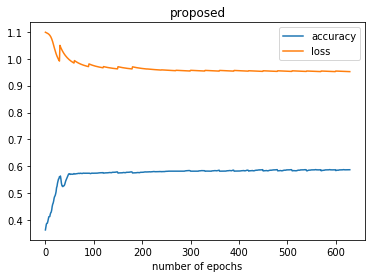

In [10]:
import matplotlib.pyplot as plt 
plt.plot(range(630),total_acc,label='accuracy')
plt.plot(range(630),total_loss,label='loss')
plt.legend()
plt.xlabel('number of epochs')
plt.title('proposed')
plt.savefig('wave 20/ga_drop.jpg')